In [ ]:
# Installing modules
!pip install nltk
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn

In [1]:
# Importing modules
import re, nltk, numpy, matplotlib
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load categorised data by media ideological affiliation
df = pd.read_csv('C:/Users/analo/OneDrive - University of Glasgow/University of Glasgow/Amsterdam Visit/ASCoR-Project/Data Files/finalcorpus.csv', encoding='latin-1')
df.head()  

,date,maintext,title,source,media_name,ideology,Congress
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,6 Ways the League of Women Voters Has Impacted...,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th
1,2015/02/10,"As state legislatures shift into high gear, ma...",Opportunities for Effective Election Reforms C...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...","Scott Walker Pushes ALEC 'Right to Work' Bill,...",http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,Nevada GOP Pushes New Gun Law Reminiscent Of '...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th


In [21]:
# counting words of original text 
from nltk.tokenize import word_tokenize
text =df['maintext'].apply(str) 
documents = [" ".join(strings.split()) for strings in text] 
string = " ".join(documents)
tokenized = word_tokenize(string)
len(tokenized)

6371235

## Pre-processing corpus

In [141]:
stop_words_file = 'C:/Users/analo/OneDrive - University of Glasgow/University of Glasgow/Amsterdam Visit/ASCoR-Project/Analysis/Descriptive-Stats/english.stop.txt' # Stopword list
new_stopwords = ['Opinion', 'New', 'Advertisement', 'advertisement','Mr', 'Advertisement\r\r\n'] # irrelevant words to add to stopword list and common words with a low idf score
idf_words = ['state', 'states','voting', 'election', 'vote', 'voters', 'voter'] # words with low idf score in entire corpus
stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

### Removing capitalised words we're not interested in

In [23]:
# removing capitalised irrelevant words from corpus
def nostop(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

     #split into words -> convert string into list
    words = letters_only_text.split()
    words =[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    
    # remove new stopwords
    cleaned_words = []
    for word in words:
        if word not in new_stopwords:
            cleaned_words.append(word)

    # converting list back to string
    return " ".join(cleaned_words)

### Converting to lower case and removing stop words

In [24]:
def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)

    # converting list back to string
    return " ".join(cleaned_words)

### removing low idf score words

In [128]:
def idfwords(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []    
    # remove stopwords
    for word in words:
        if word not in idf_words:
            cleaned_words.append(word)

    # converting list back to string
    return " ".join(cleaned_words)

In [27]:
test_sentence1 = "Opinion to advertisement New how the preprocessing function works...!"
nostop(test_sentence1)

'to how the preprocessing function works'

In [28]:
test_sentence2 = "this is a Opinion to advertisement New how the preprocessing function works...!"
preprocess(test_sentence2)


'opinion advertisement preprocessing function works'

In [131]:
test_sentence3 = "this is a states to advertisement New how the preprocessing function works...!"
preprocess(test_sentence3)

'states advertisement preprocessing function works'

In [ ]:
df['maintext']=df['maintext'].apply(str) # Converting text column into string so that preprocessing works
df['text_cap'] = df['maintext'].apply(nostop)
df['text'] = df['text_cap'].apply(preprocess)
df.head()

In [142]:
# preprocess title
df['title']=df['title'].apply(str) # Converting text column into string so that preprocessing works
df['title'] = df['title'].apply(nostop)
df['title'] = df['title'].apply(preprocess)
df['title'] = df['title'].apply(idfwords)
df.head()

df['title'][7]

'usa today'

In [30]:
# Checking amount of words after preprocessing
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

2550266

In [31]:
# Filtering words that appear less than 3 times overall
from collections import Counter
from itertools import chain

# split words into lists
v = df['text'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
df['text'] = [' '.join([j for j in i if c[j] > 3]) for i in v]

In [32]:
# Checking amount of words after preprocessing
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

2511272

## Word Frequencies

In [40]:
# creating two different datasets for media split by ideology
ideology = df.groupby("ideology")
left = ideology.get_group('left')
right = ideology.get_group('right')

1714

In [69]:
# Finding top words in overall corpus
cnt_df = (pd.DataFrame(Counter(" ".join(df["text"]).split(" ")).most_common(20))) #another way of finding most common words in corpus
cnt_df.columns=['word', 'freq']

# Top right media words
cnt_right = (pd.DataFrame(Counter(" ".join(right["text"]).split(" ")).most_common(20)))
cnt_right.columns=['word', 'freq']

# Top left media words
cnt_left = (pd.DataFrame(Counter(" ".join(left["text"]).split(" ")).most_common(20)))
cnt_left.columns=['word', 'freq']

,word,freq
0,election,6867
1,voter,6356
2,state,5970
3,voting,5520
4,people,4943
5,vote,4386
6,id,4120
7,democrats,3894
8,law,3828
9,voters,3739


In [72]:
# Defining function to plot top words
import pandas as pd
import matplotlib.pyplot as plt

def scatterplot(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(15, 7))
  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, alpha=0.70)
 
  #adds a title and axes labels
  ax.set_title('Word Frequencies')
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Word')
 
  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  #adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()

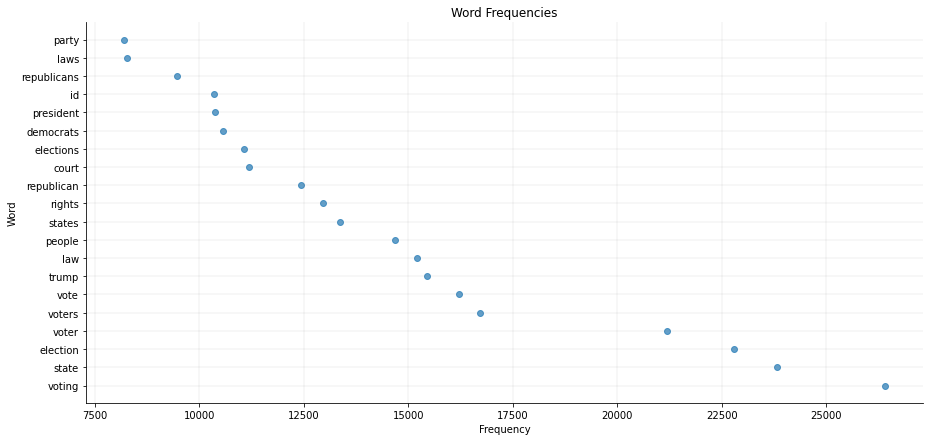

In [74]:
# Plotting top words
scatterplot(cnt_df, 'freq', 'word')

In [151]:
# Sorting ngrams by frequency
from nltk.util import ngrams
n_gram = 2
ngram = pd.DataFrame(Counter(ngrams(" ".join(df["text"]).split(), n_gram)).most_common(10))
ngram.columns=['word', 'freq']
ngram

,word,freq
0,"(voting, rights)",7327
1,"(voter, id)",6283
2,"(supreme, court)",4407
3,"(north, carolina)",3582
4,"(united, states)",3319
5,"(civil, rights)",3057
6,"(voter, fraud)",2950
7,"(rights, act)",2688
8,"(voter, registration)",2635
9,"(donald, trump)",2422


In [ ]:
# Finding names in corpus
test = df['text_cap'][9]
re.findall(r"[A-Z][a-z]+?\s+(?:[A-Z][a-z]*\.?\s*)?[A-Z][a-z]+", test)

Now that we know common bigrams we can go back to preprocessing and join these in the text so that they are subsequently treated as 1 token instead of 2. The following bigrams are joined:
- Supreme court
- north carolina
- united states
- donald trump
- white house

We also change mr trump to donald trump

In [145]:
def bigrams(raw_text):
    text = raw_text.replace("supreme court", "supreme_court")
    text = text.replace("donald trump", "donald_trump")
    text = text.replace("north carolina", "north_carolina")
    text = text.replace("united states", "united_states")
     # convert to lower case and split into words -> convert string into list
    words = text.split()
    words =[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    # converting list back to string
    return " ".join(words)

In [104]:
test_sentence3 = "this is a id donald trump to advertisement New how the preprocessing function works...!"
bigrams(test_sentence3)

'this is a id donald_trump to advertisement New how the preprocessing function works...!'

In [146]:
df['text_bigrams'] = df['text'].apply(bigrams)
df['title'] = df['title'].apply(bigrams)

In [ ]:
# Most frequent words
cnt_bg = pd.DataFrame(Counter(" ".join(df["text_bigrams"]).split(" ")).most_common(60))
cnt_bg.columns=['word', 'freq']
cnt_bg

In [126]:
df.head()

,date,maintext,title,source,media_name,ideology,Congress,text,text_cap,text_bigrams
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,ways league women voters impacted life,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th,honor anniversary list things americans part l...,In honor of our anniversary here s a list of s...,honor anniversary list things americans part l...
1,2015/02/10,"As state legislatures shift into high gear, ma...",opportunities effective election reforms spear...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th,state legislatures shift high gear election re...,As state legislatures shift into high gear man...,state legislatures shift high gear election re...
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...",scott walker pushes alec work bill divide conq...,http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th,file tuesday nov file photo wisconsin republic...,FILE In a Tuesday Nov file photo Wisconsin Rep...,file tuesday nov file photo wisconsin republic...
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,ted strickland announces running senate,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th,ohio gov ted strickland announced wednesday ll...,Former Ohio Gov Ted Strickland D announced Wed...,ohio gov ted strickland announced wednesday ll...
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,nevada gop pushes gun law reminiscent stand gr...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th,nevada senate minority leader michael roberson...,Nevada Senate Minority Leader Michael Roberson...,nevada senate minority leader michael roberson...


In [110]:
# save data to csv file
df.to_csv('preprocessed.csv', index = False)

In [149]:
# creating two different datasets for media split by ideology
ideology = df.groupby("ideology")
left = ideology.get_group('left')
right = ideology.get_group('right')

len(right)

1714

In [144]:
# export text data to txt file for Iramuteq analysis
text_l =left['title'].apply(str) 
with open('left.txt', 'w') as f:
    for line in text_l:
        f.write(line)
        f.write(' ')

In [150]:
text_r =right['title'].apply(str) 
with open('right.txt', 'w') as f:
    for line in text_r:
        f.write(line)
        f.write(' ')